In [60]:
# loads path to your input files : base_processed, base_raw, base_models...
%run init_notebook.py

In [61]:
# Optional : list the available files to chose one for the next cell
import os

csv_files = [file for file in os.listdir(base_raw) if file.endswith('.csv')]
print("\nAvailable files in the raw folder:\n")
for file in csv_files:
    print("* "+file)



Available files in the raw folder:

* dummy_fin_data_v02.csv
* example_fin_data_v03.csv
* status_20250331.csv


In [ ]:
# enter the file name (no extension) you want to work with
my_data_file = 'example_fin_data_v03'  # default example
# my_data_file = 'your_file'

map_definition='50m' # '110m', '50m', '10m' : resolution of the map, as downloaded from https://www.naturalearthdata.com/downloads/50m-cultural-vectors/


In [63]:
# Remove the .csv extension if present
if my_data_file.endswith('.csv'):
    my_data_file = my_data_file[:-4]  # Strip the last 4 characters (.csv)



In [18]:
# if not yet installed in your python virtual enviropnment
!pip install ipywidgets 

In [19]:
# for notebook display mode only (not in VScode)
"""
import os
import ipywidgets as widgets
from IPython.display import display

# Define the directory to list files from
file_path = base_raw


# Create a dropdown widget to list files
def update_files(change):
    selected_file.value = change['new']

files = os.listdir(file_path)
file_dropdown = widgets.Dropdown(options=files, description='Files:')
selected_file = widgets.Text(value='', description='Selected File:')

file_dropdown.observe(update_files, names='value')

# Display the dropdown and selected file
display(file_dropdown, selected_file)
my_data_file = selected_file.value
"""

"\nimport os\nimport ipywidgets as widgets\nfrom IPython.display import display\n\n# Define the directory to list files from\nfile_path = base_raw\n\n\n# Create a dropdown widget to list files\ndef update_files(change):\n    selected_file.value = change['new']\n\nfiles = os.listdir(file_path)\nfile_dropdown = widgets.Dropdown(options=files, description='Files:')\nselected_file = widgets.Text(value='', description='Selected File:')\n\nfile_dropdown.observe(update_files, names='value')\n\n# Display the dropdown and selected file\ndisplay(file_dropdown, selected_file)\nmy_data_file = selected_file.value\n"

In [64]:
import pandas as pd
# Read the CSV file into a new DataFrame
df = pd.read_csv(base_raw + my_data_file + '.csv')

# in case needed
# print(df)

In [65]:
import numpy as np

# Replace NaN values in 'geography' and 'type' with 'not specified'
df['geography'] = df['geography'].fillna('not specified')
df['type'] = df['type'].fillna('not specified')

# Get the unique types
types = df['type'].unique()

# Group by 'geography' and calculate the sum of 'amount' for each 'type'
grouped = df.groupby(['geography', 'type'])['amount'].sum().unstack(fill_value=0)

# Convert the grouped data into a NumPy array of tuples
result_array = np.array([tuple(row) for row in grouped.values])

# Display the result
# print(result_array)

In [44]:
# for developper info only
"""
# Display the grouped DataFrame
print(grouped)

# Display the row index (geography values)
print("Row index (geography):", grouped.index.tolist())

# Display the column names (type values)
print("Column names (types):", grouped.columns.tolist())
"""

'\n# Display the grouped DataFrame\nprint(grouped)\n\n# Display the row index (geography values)\nprint("Row index (geography):", grouped.index.tolist())\n\n# Display the column names (type values)\nprint("Column names (types):", grouped.columns.tolist())\n'

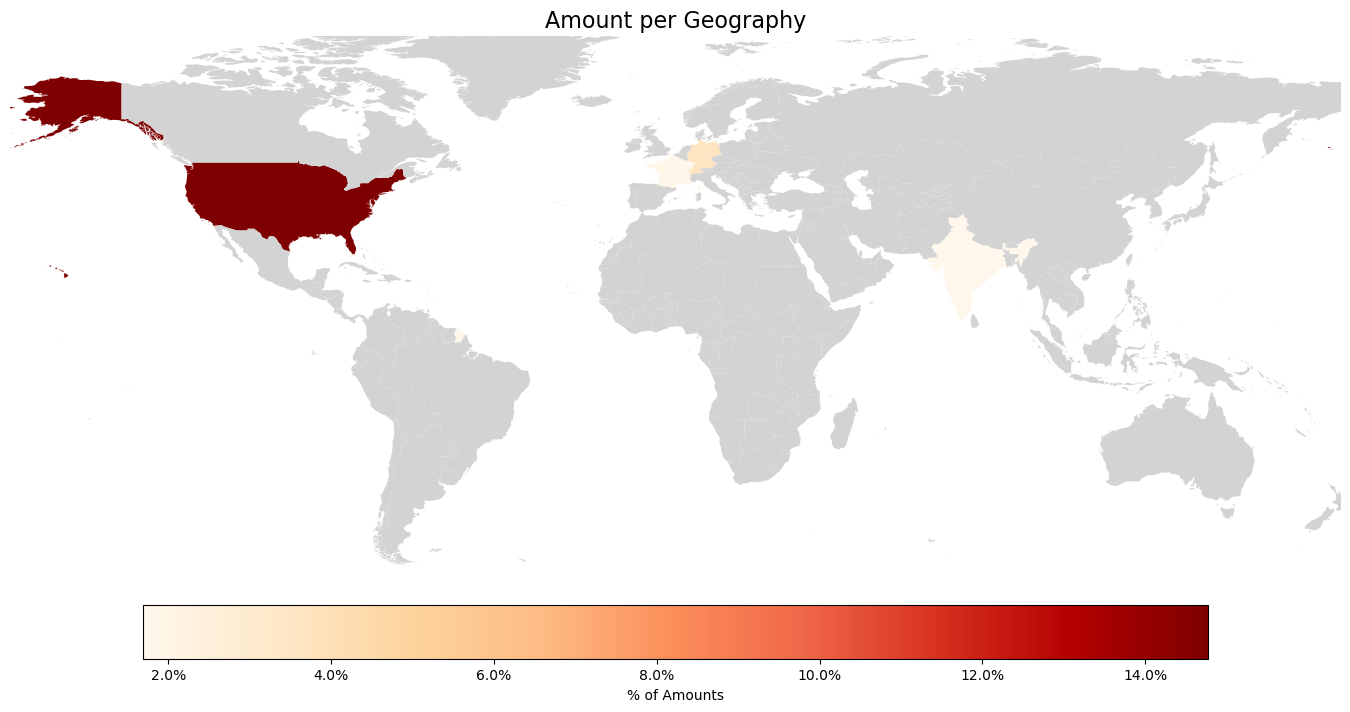

In [77]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Replace NaN values in 'geography' with 'not specified'
df['geography'] = df['geography'].fillna('not specified')

transformations = {
    "US": "United States of America",
    "USA": "United States of America",
    "Congo": "Democratic Republic of the Congo",
    "Bahamas": "The Bahamas",
    "UAE": "United Arab Emirates",
    "NL": "Netherlands",
    "CH": "Switzerland"
}
df['geography'] = df['geography'].map(transformations).where(df['geography'].map(transformations).notna(), df['geography'])



# Group by 'geography' and calculate the sum of 'amount'
grouped_geography = df.groupby('geography')['amount'].sum().reset_index()

# Calculate percentages
total_amount = grouped_geography['amount'].sum()  # Total amount for normalization
grouped_geography['percentage'] = (grouped_geography['amount'] / total_amount) * 100


# Load the world map shapefile using GeoPandas
# Path to the dataset shapefile
shapefile_path = "../../data/for_geopandas/ne_"+map_definition+"_admin_0_countries.shp"
# Load the world map shapefile
world = gpd.read_file(shapefile_path)


# Merge the world map with the grouped data
# Ensure the 'geography' column matches the 'name' column in the world map
world = world.merge(grouped_geography, how='left', left_on='ADMIN', right_on='geography')

# Plot the world map
fig, ax = plt.subplots(figsize=(14,16))
world.plot(
    column='percentage',  # Use the 'amount' column for coloring
    cmap='OrRd',  # Color map (e.g., 'OrRd' for orange-red)
    legend=True,  # Add a legend
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},  # Handle missing data
    legend_kwds={
    "shrink": 0.8,                   # Shrink the legend size to fit
    "label": "% of Amounts",       # Add a label to the legend
    "format": "%.1f%%",              # Format the legend values as percentages
    "orientation": "horizontal",     # Display the legend horizontally
    "pad": 0.02,                     # Adjust padding
}

)

# Set axis limits to focus on Europe
ax.set_xlim(-170, 176)  # Longitude range
ax.set_ylim(-58, 82)   # Latitude range

# Set aspect ratio
ax.set_aspect('equal')  # Ensure the map is not distorted
# Tighten layout to maximize map space
plt.tight_layout()


plt.title('Amount per Geography', fontsize=16)

# Turn off the grid and axis
ax.axis("off")


# Save as an image file
save_path = base_images + my_data_file + '_map_world.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

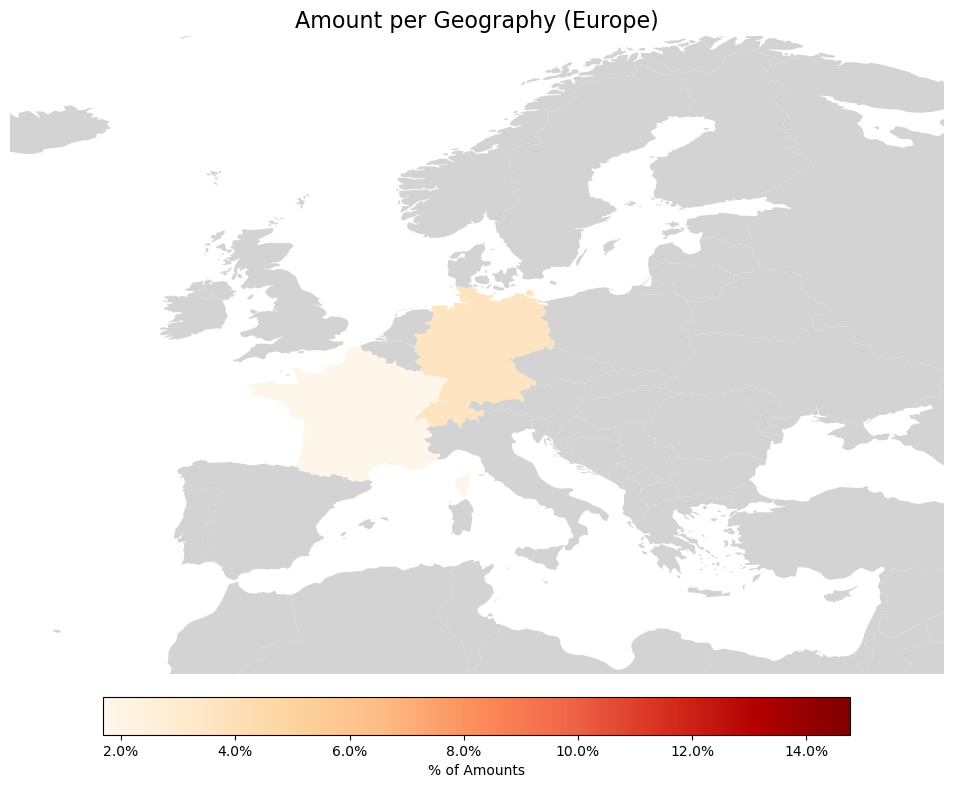

In [69]:
import matplotlib.pyplot as plt

# Plot the world map
fig, ax = plt.subplots(figsize=(10, 12))
world.plot(
    column='percentage',  # Use the 'percentage' column for coloring
    cmap='OrRd',  # Color map (e.g., 'OrRd' for orange-red)
    legend=True,  # Add a legend
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},  # Handle missing data
    legend_kwds={
        "shrink": 0.8,                   # Shrink the legend size to fit
        "label": "% of Amounts",         # Add a label to the legend
        "format": "%.1f%%",              # Format the legend values as percentages
        "orientation": "horizontal",     # Display the legend horizontally
        "pad": 0.02,                     # Adjust padding
    }
)

# Set axis limits to focus on Europe
ax.set_xlim(-20, 40)  # Longitude range
ax.set_ylim(30, 71)   # Latitude range

# Set aspect ratio
ax.set_aspect('equal')  # Ensure the map is not distorted

# Tighten layout to maximize map space
plt.tight_layout()

plt.title('Amount per Geography (Europe)', fontsize=16)

# Turn off the grid and axis
ax.axis("off")

# Save as an image file
save_path = base_images + my_data_file + '_map_europe.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [38]:
#print(world['ADMIN'].unique()) # in case needed to map countries names